# Tutorials for Developing Scientific Workflows in Pycroscopy - Part 1: Data Translation

#### Suhas Somnath
8/8/2017

This set of notebooks will serve as examples for developing and end-to-end workflows for and using pycroscopy. 

__In this example, we extract data and parameters from a Scanning Tunnelling Spectroscopy (STS) raw data file, as obtained from an Omicron STM, and write these to a pycroscopy compatible data file.__

### Prerequisites:

Before proceeding with this example series, we recommend reading the previous documents to learn more about:
1. Data and file formats
    * Why you should care about data formats
    * Current state of data formats in microscopy
    * Structuring data in pycroscopy
2. HDF5 file format

## Introduction to Data Translation

Before any data analysis, we need to access data stored in the raw file(s) generated by the microscope. Often, the data and parameters in these files are __not__ straightforward to access. In certain cases, additional / dedicated software packages are necessary to access the data while in many other cases, it is possible to extract the necessary information from built-in __numpy__ or similar python packages included with __anaconda__.

Pycroscopy aims to make data access, storage, curation, etc. simply by storing the data along with all relevant parameters in a single __.hdf5__ or __.h5__ file. 

The process of copying data from the original format to __pycroscopy compatible hdf5 files__ is called __Translation__ and the classes available in pycroscopy that perform these operation are called __Translators__

## Writing Your First Data Translator

__The goal in this section is to trandslate the .asc file obtained from an Omicron microscope into a pycroscopy compatible .h5 file. __
While there is an __AscTranslator__ avialable in pycroscopy that can translate these files in just a __single__ line, we will intentionally assume that no such translator is avialable. Using a handful of useful functions in pycroscopy, we will translate the files from the source __.asc__ format to the pycroscopy compatible __.h5__ in just a few lines. The code developed below is essentially the __AscTranslator__. The same methodology can be used to translate other data formats

### Setting up the notebook

There are a few setup procedures that need to be followed before any code is written. In this step, we simply load a few python packages that will be necessary in the latery steps.  

In [1]:
# downloading packages:
!pip install -U wget numpy h5py matplotlib pycroscopy

# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# In case some of these packages are not installed, install them
#!pip install -U os wget numpy h5py matplotlib pycroscopy

# The package for accessing files in directories, etc.:
import os
import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Finally import pycroscopy for certain scientific analysis:
import pycroscopy as px

# set up notebook to show plots within the notebook
% matplotlib inline

### 0. Select the Raw Data File:

In [2]:
# download the data file from Github:
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/STS.asc'
data_file_path = 'temp.asc'
if os.path.exists(data_file_path):
    os.remove(data_file_path)
_ = wget.download(url, data_file_path)

### 1. Exploring the Raw Data File

Inherently, one may not know how to read these __.asc__ files. One option is to try and read the file as a text file one line at a time. 

It turns out that these .asc files are effectively the standard __ASCII__ text files. 

Here is how we tested to see if the __asc__ files could be interpreted as text files. Below, we read just thefirst 10 lines in the file

In [3]:
with open(raw_file_path, 'r') as file_handle:
    for lin_ind in range(10):
        print(file_handle.readline())

# File Format = ASCII

# Created by SPIP 4.6.5.0 2016-09-22 13:32

# Original file: C:\Users\Administrator\AppData\Roaming\Omicron NanoTechnology\MATRIX\default\Results\16-Sep-2016\I(V) TraceUp Tue Sep 20 09.17.08 2016 [14-1]  STM_Spectroscopy STM

# x-pixels = 100

# y-pixels = 100

# x-length = 29.7595

# y-length = 29.7595

# x-offset = -967.807

# y-offset = -781.441

# z-points = 500



### 2. Loading the data

Now that we know that these files are simple text files, we can manually go through the file to find out which lines are important, at what lines the data starts etc. 

Manual investigation of such .asc files revealed that these files are always formatted in the same way. Also, they contain parameters in the first 403 lines and then contain data which is arranged as one pixel per row.

STS experiments result in 3 dimensional datasets (X, Y, current). In other words, a 1D array of current data (as a function of excitation bias) is sampled at every location on a two dimensional grid of points on the sample.

By knowing where the parameters are located and how the data is structured, it is possible to extract the necessary information from these files.

Since we know that the data sizes (<200 MB) are much smaler than the physical memory of most computers, we  can start by safely loading the contents of the entire file to memory

In [4]:
# Extracting the raw data into memory
file_handle = open(raw_file_path, 'r')
string_lines = file_handle.readlines()
file_handle.close()

### 3. Read the parameters

The parameters in these files are present in the first few lines of the file

In [5]:
# Reading parameters stored in the first few rows of the file
parm_dict = dict()
for line in string_lines[3:17]:
    line = line.replace('# ', '')
    line = line.replace('\n', '')
    temp = line.split('=')
    test = temp[1].strip()
    try:
        test = float(test)
        # convert those values that should be integers:
        if test % 1 == 0:
            test = int(test)
    except ValueError:
        pass
    parm_dict[temp[0].strip()] = test

# Print out the parameters extracted
for key in parm_dict.keys():
    print(key, ':\t', parm_dict[key])

x-offset :	 -967.807
y-offset :	 -781.441
x-length :	 29.7595
z-range :	 2000000000
y-pixels :	 100
x-pixels :	 100
z-offset :	 1116.49
value-unit :	 nA
scanspeed :	 59519000000
voidpixels :	 0
z-section :	 491
z-points :	 500
y-length :	 29.7595
z-unit :	 nV


### 3.a Prepare to read the data

Before we read the data, we need to make an empty array to store all this data. In order to do this, we need to read the dictionary of parameters we made in step 2 and extract necessary quantities

In [6]:
num_rows = int(parm_dict['y-pixels'])
num_cols = int(parm_dict['x-pixels'])
num_pos = num_rows * num_cols
spectra_length = int(parm_dict['z-points'])

### 3.b Read the data

Data is present after the first 403 lines of parameters. 

In [7]:
# num_headers = len(string_lines) - num_pos
num_headers = 403

# Extract the STS data from subsequent lines
raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)
for line_ind in range(num_pos):
    this_line = string_lines[num_headers + line_ind]
    string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
    raw_data_2d[line_ind] = np.array(string_spectrum, dtype=np.float32)

### 4.a Preparing some necessary parameters


In [8]:
max_v = 1 # This is the one parameter we are not sure about

folder_path, file_name = path.split(raw_file_path)
file_name = file_name[:-4] + '_'

# Generate the x / voltage / spectroscopic axis:
volt_vec = np.linspace(-1 * max_v, 1 * max_v, spectra_length)

h5_path = path.join(folder_path, file_name + '.h5')

### 4b. Calling the NumpyTranslator to create the pycroscopy data file

The NumpyTranslator simplifies the ceation of pycroscopy compatible datasets. It handles the file creation, dataset creation and writing, creation of ancillary datasets, datagroup creation, writing parameters, linking ancillary datasets to the main dataset etc. With a single call to the NumpyTranslator, we complete the translation process. 

In [9]:
tran = px.io.NumpyTranslator()
h5_path = tran.translate(h5_path, raw_data_2d, num_rows, num_cols, 
                         qty_name='Current', data_unit='nA', spec_name='Bias', 
                         spec_unit='V', spec_val=volt_vec, scan_height=100, 
                         scan_width=200, spatial_unit='nm', data_type='STS', 
                         translator_name='ASC', parms_dict=parm_dict)

## Notes on pycroscopy translation
* Steps 1-3 would be performed anyway in order to begin data analysis
* The actual pycroscopy translation step are reduced to just 3-4 lines in step 4.
* While this approach is feasible and encouraged for simple and small data, it may be necessary to use lower level calls to write efficient translators

### Verifying the newly written H5 file:
* We will only perform some simple and quick verification to show that the data has indeed been translated corectly. 
* Please see the next notebook in the example series to learn more about reading and accessing data. 

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


<IPython.core.display.Javascript object>


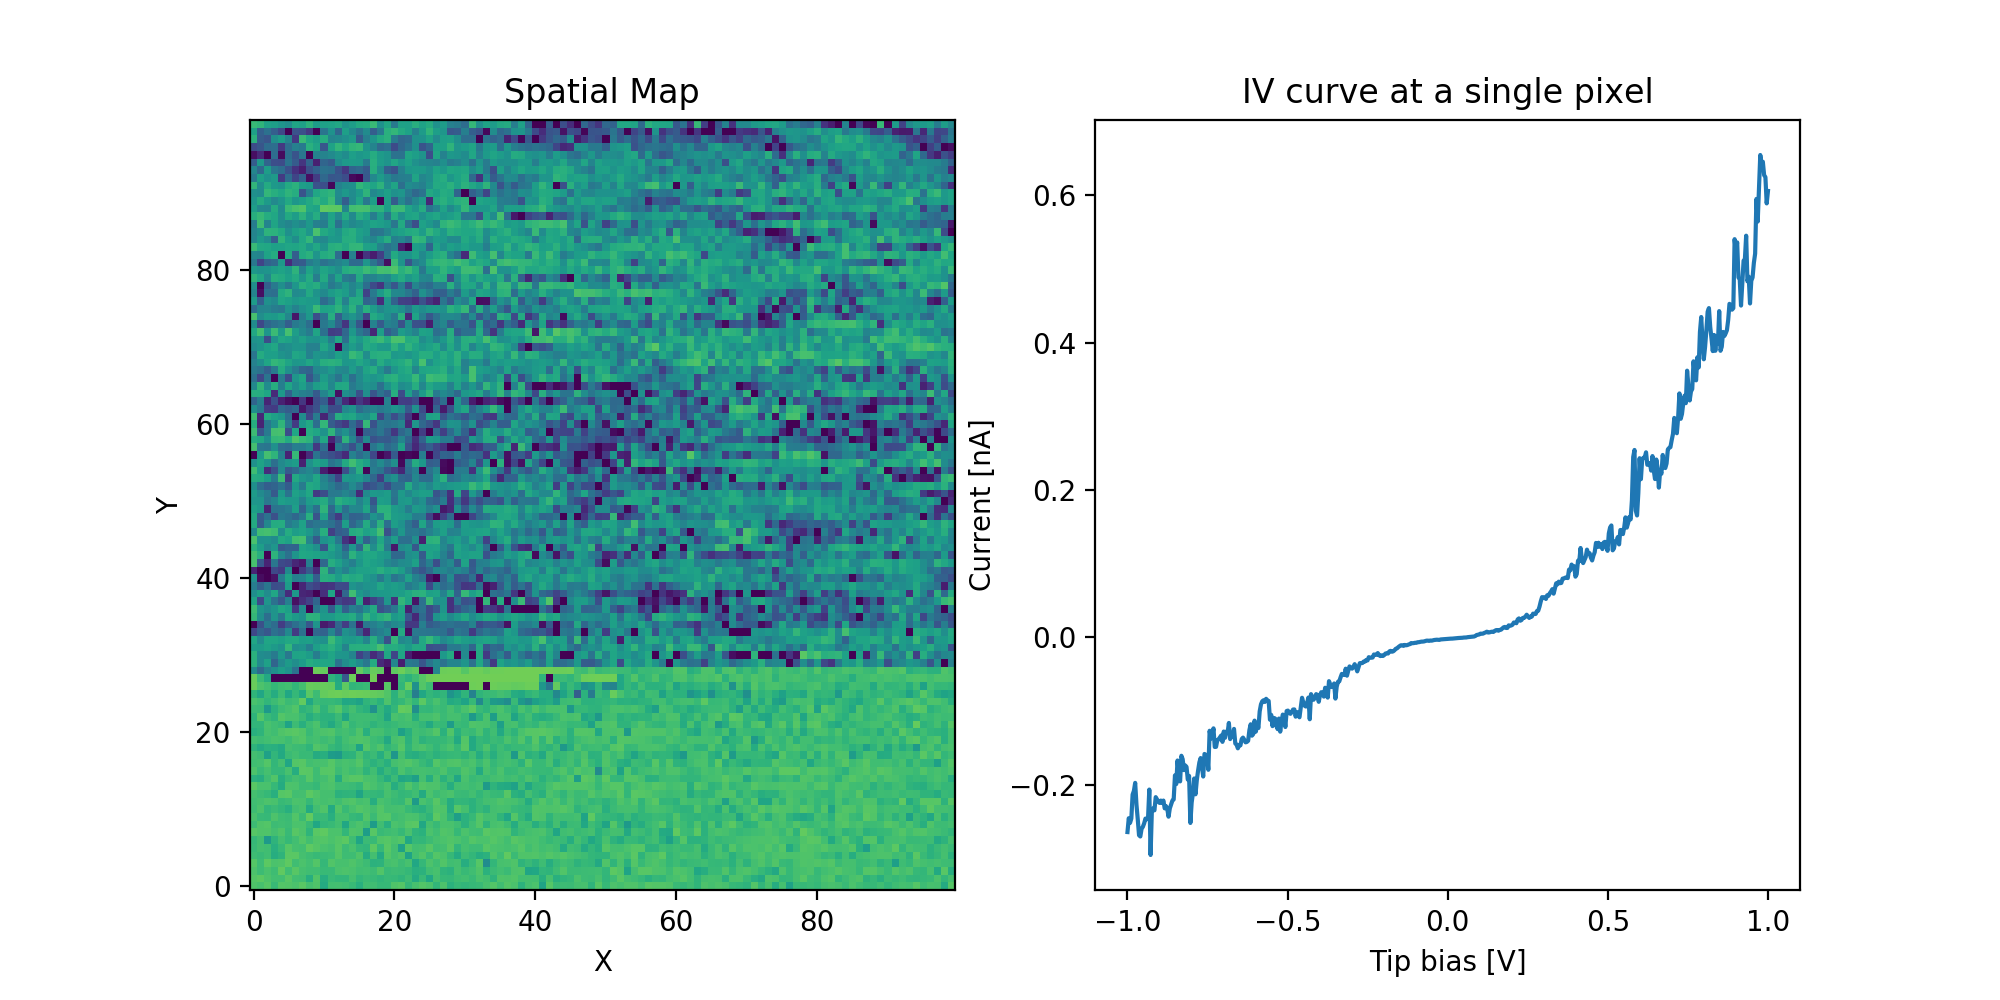

In [10]:
with h5py.File(h5_path, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    px.hdf_utils.print_tree(h5_file)
    
    h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
    fig, axes = plt.subplots(ncols=2, figsize=(11,5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    px.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]), 
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

In [ ]:
# Remove both the original and translated files:
os.remove(h5_path)
os.remove(data_file_path)

## Next example  - Reading and Acessing Data